
# Sparse Norm Inversion of 2D Seismic Tomography Data

Here we 2D straight ray tomography data to recover a velocity/slowness model.
We formulate the inverse problem as an iteratively
re-weighted least-squares (IRLS) optimization problem. For this tutorial, we
focus on the following:

    - Defining the survey from xyz formatted data
    - Defining the inverse problem (data misfit, regularization, optimization)
    - Specifying directives for the inversion
    - Setting sparse and blocky norms
    - Plotting the recovered model


## Import Modules




In [13]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tarfile

from discretize import TensorMesh

from simpeg import (
    data,
    maps,
    regularization,
    data_misfit,
    optimization,
    inverse_problem,
    directives,
    inversion,
    utils,
)

from simpeg.seismic import straight_ray_tomography as tomo

# sphinx_gallery_thumbnail_number = 3

## Read data file


In [14]:
# path to the directory containing our data
dir_path = './data/'

# files to work with
data_filename = dir_path + "tomography2D_data.obs"
model_filename = dir_path + "true_model_2D.txt"

## Load Data, Define Survey and Plot

Here we load the observed data, define the survey geometry and
plot the data.




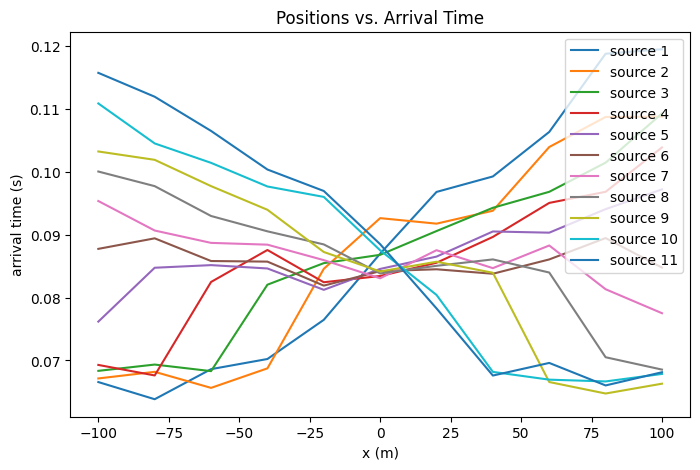

In [17]:
# Load data
dobs = np.loadtxt(str(data_filename))

# Extract source and receiver locations and the observed data
xy_sources = dobs[:, 0:2]
xy_receivers = dobs[:, 2:4]
dobs = dobs[:, -1]

# Define survey
unique_sources, k = np.unique(xy_sources, axis=0, return_index=True)
n_sources = len(k)
k = np.r_[k, len(dobs) + 1]

source_list = []
for ii in range(0, n_sources):
    # Receiver locations for source ii
    receiver_locations = xy_receivers[k[ii] : k[ii + 1], :]
    receiver_list = [tomo.Rx(receiver_locations)]

    # Source ii location
    source_location = xy_sources[k[ii], :]
    source_list.append(tomo.Src(receiver_list, source_location))

# Define survey
survey = tomo.Survey(source_list)

# Define a data object. Uncertainties are added later
data_obj = data.Data(survey, dobs=dobs)

# Plot
n_source = len(source_list)
n_receiver = len(xy_receivers)

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
obs_string = []

for ii in range(0, n_source):
    x_plotting = xy_receivers[k[ii] : k[ii + 1], 0]
    dobs_plotting = dobs[k[ii] : k[ii + 1]]
    ax.plot(x_plotting, dobs_plotting)
    obs_string.append("source {}".format(ii + 1))

ax.set_xlabel("x (m)")
ax.set_ylabel("arrival time (s)")
ax.set_title("Positions vs. Arrival Time")
ax.legend(obs_string, loc="upper right")

plt.show()

## Assign Uncertainties

Inversion with SimPEG requires that we define standard deviation on our data.
This represents our estimate of the noise in our data. In this case, we
assign a 5 percent uncertainty to each datum.




In [18]:
# Compute standard deviations
std = 0.02 * np.abs(dobs)

# Add standard deviations to data object
data_obj.standard_deviation = std

## Defining a Tensor Mesh

Here, we create the tensor mesh that will be used to invert the data.




In [19]:
dh = 10.0  # cell width
N = 21  # number of cells in X and Y direction
hx = [(dh, N)]
hy = [(dh, N)]
mesh = TensorMesh([hx, hy], "CC")

In [21]:
mesh

TensorMesh: 441 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     21       -105.00        105.00     10.00     10.00    1.00
   y     21       -105.00        105.00     10.00     10.00    1.00

## Starting/Reference Model and Mapping on Tensor Mesh

Here, we create starting and/or reference models for the inversion as
well as the mapping from the model space to the slowness. Starting and
reference models can be a constant background value or contain a-priori
structures. Here, the background is 3000 m/s.




In [22]:
# Define density contrast values for each unit in g/cc. Don't make this 0!
# Otherwise the gradient for the 1st iteration is zero and the inversion will
# not converge.
background_velocity = 3000.0

# Define mapping from model space to the slowness on mesh cells
model_mapping = maps.ReciprocalMap()

# Define starting model
starting_model = background_velocity * np.ones(mesh.nC)

In [23]:
# model_mapping * starting_model

## Define the Physics

Here, we define the physics of the 2D straight ray tomography problem by
using the simulation class.




In [27]:
# Define the forward simulation. To do this we need the mesh, the survey and
# the mapping from the model to the slowness value on each cell.
simulation = tomo.Simulation(mesh, survey=survey, slownessMap=model_mapping)

## Define the Inverse Problem

The inverse problem is defined by 3 things:

    1) Data Misfit: a measure of how well our recovered model explains the field data
    2) Regularization: constraints placed on the recovered model and a priori information
    3) Optimization: the numerical approach used to solve the inverse problem|


In [28]:
mesh.h

(array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10.]),
 array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10.]))

In [86]:
# Define the data misfit. Here the data misfit is the L2 norm of the weighted
# residual between the observed data and the data predicted for a given model.
# Within the data misfit, the residual between predicted and observed data are
# normalized by the data's standard deviation.
dmis = data_misfit.L2DataMisfit(data=data_obj, simulation=simulation)

# Define the regularization (model objective function). Here, 'p' defines the
# the norm of the smallness term and 'q' defines the norm of the smoothness
# term.

reg = regularization.WeightedLeastSquares(
    mesh, mapping=maps.IdentityMap(nP=mesh.nC),
    alpha_s=1e-5,
    alpha_x=1,
    alpha_y=0,
)

# reg = regularization.Sparse(mesh, mapping=maps.IdentityMap(nP=mesh.nC))
# p = 0
# qx = 0.5
# qy = 0.5
# reg.norms = [p, qx, qy]

# Define how the optimization problem is solved.
opt = optimization.ProjectedGNCG(
    maxIter=10, lower=0.0, upper=1e6, maxIterLS=20, maxIterCG=50, tolG=1e-10,
    # cg_maxiter=10, cg_rtol=1e-3
)

# Here we define the inverse problem that is to be solved
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

## Define Inversion Directives

Here we define any directiveas that are carried out during the inversion. This
includes the cooling schedule for the trade-off parameter (beta), stopping
criteria for the inversion and saving inversion results at each iteration.




In [87]:
# Reach target misfit for L2 solution, then use IRLS until model stops changing.
# update_IRLS = directives.UpdateIRLS(
#     f_min_change=1e-4,
#     max_irls_iterations=30,
#     irls_cooling_factor=1.5,
#     misfit_tolerance=1e-2,
# )

# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=2e0)
beta_schedule = directives.BetaSchedule(coolingFactor=2, coolingRate=1)
target = directives.TargetMisfit(chifact=1.)
precond = directives.UpdatePreconditioner()

# Save output at each iteration
saveDict = directives.SaveOutputDictEveryIteration()

# Define the directives as a list
directives_list = [starting_beta, beta_schedule, saveDict]

## Running the Inversion

To define the inversion object, we need to define the inversion problem and
the set of directives. We can then run the inversion.




In [88]:
# Here we combine the inverse problem and the set of directives
inv = inversion.BaseInversion(inv_prob, directives_list)

# Run inversion
recovered_model = inv.run(starting_model)


Running inversion with SimPEG v0.25.0
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Pardiso and no solver_opts.***
                    
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  3.55e-05  8.95e+03  0.00e+00  8.95e+03    1.46e+00      0              
   1  1.78e-05  1.40e+03  8.07e+06  1.54e+03    1.07e+00      0              
   2  8.88

In [89]:
iterations = list(saveDict.outDict.keys())

In [90]:
saveDict.outDict[1].keys()

dict_keys(['iter', 'beta', 'phi_d', 'phi_m', 'f', 'm', 'dpred'])

In [91]:
iteration = 1
saveDict.outDict[iteration].keys()

dict_keys(['iter', 'beta', 'phi_d', 'phi_m', 'f', 'm', 'dpred'])

In [92]:
phi_d = []
phi_m = []

for iteration in iterations:
    phi_d.append(saveDict.outDict[iteration]['phi_d'])
    phi_m.append(saveDict.outDict[iteration]['phi_m'])    

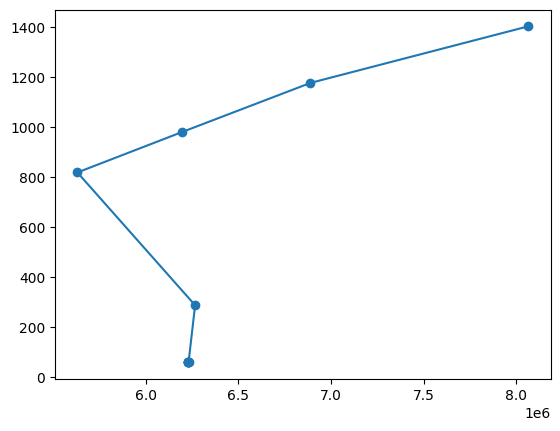

In [93]:
plt.plot(phi_m, phi_d, 'o-')

## Plotting True Model and Recovered Model




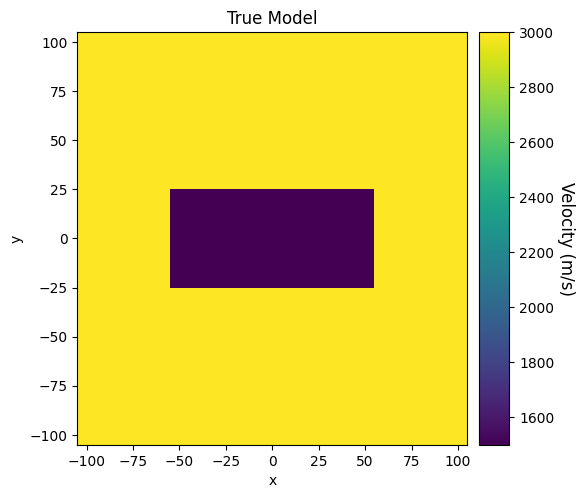

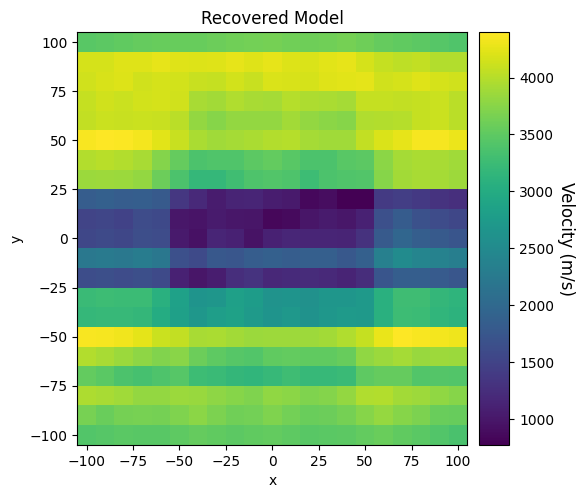

In [94]:
iteration = 5
recovered_model = saveDict.outDict[iteration]['m']

# Load the true model
true_model = np.loadtxt(str(model_filename))

# Plot True Model
fig = plt.figure(figsize=(6, 5.5))

ax1 = fig.add_axes([0.15, 0.15, 0.65, 0.75])
mesh.plot_image(true_model, ax=ax1, grid=False, pcolor_opts={"cmap": "viridis"})
ax1.set_title("True Model")

ax2 = fig.add_axes([0.82, 0.15, 0.05, 0.75])
norm = mpl.colors.Normalize(vmin=np.min(true_model), vmax=np.max(true_model))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.viridis
)
cbar.set_label("Velocity (m/s)", rotation=270, labelpad=15, size=12)

plt.show()

# Plot Recovered Model
fig = plt.figure(figsize=(6, 5.5))

ax1 = fig.add_axes([0.15, 0.15, 0.65, 0.75])
mesh.plot_image(recovered_model, ax=ax1, grid=False, pcolor_opts={"cmap": "viridis"})
ax1.set_title("Recovered Model")

ax2 = fig.add_axes([0.82, 0.15, 0.05, 0.75])
norm = mpl.colors.Normalize(vmin=np.min(recovered_model), vmax=np.max(recovered_model))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.viridis
)
cbar.set_label("Velocity (m/s)", rotation=270, labelpad=15, size=12)

plt.show()

In [95]:
dpred = inv_prob.dpred.copy()

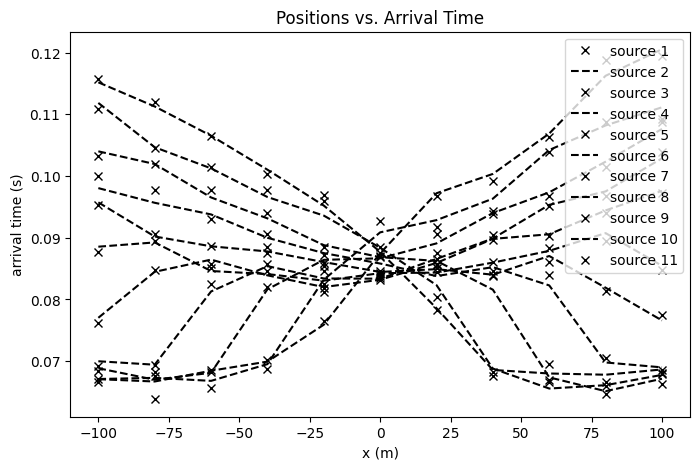

In [96]:
iteration = 7
dpred = saveDict.outDict[iteration]['dpred']

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)

for ii in range(0, n_source):
    x_plotting = xy_receivers[k[ii] : k[ii + 1], 0]
    dobs_plotting = dobs[k[ii] : k[ii + 1]]
    dpred_plotting = dpred[k[ii] : k[ii + 1]]
    ax.plot(x_plotting, dobs_plotting, 'kx')
    ax.plot(x_plotting, dpred_plotting, 'k--')
    # obs_string.append("source {}".format(ii + 1))

ax.set_xlabel("x (m)")
ax.set_ylabel("arrival time (s)")
ax.set_title("Positions vs. Arrival Time")
ax.legend(obs_string, loc="upper right")

plt.show()